# Multi-modal RAG with LangChain

## SetUp

Install the dependencies you need to run the notebook.

In [3]:
ls


/bin/bash: /home/jac/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
'2022_SOD_survey[1].pdf'*   Untitled.ipynb*   langchain_multimodal.ipynb*


### Partition PDF tables, text, and images

In [1]:
from unstructured.partition.pdf import partition_pdf


In [2]:
from unstructured.partition.pdf import partition_pdf

output_path = "/mnt/c/Users/91940/projects/Prj/Doc chatbot/"
file_path = output_path + 'DSE_3121_Slide-9_Generative Adversarial Networks.pdf'
# Reference: https://docs.unstructured.io/open-source/core-functionality/chunking
chunks = partition_pdf(
    filename=file_path,
    infer_table_structure=True,            
    strategy="hi_res",                     

    extract_image_block_types=["Image","Table"],
    #extract_image_block_output_dir=
    extract_image_block_output_dir=output_path,
    

    extract_image_block_to_payload=True,   

    chunking_strategy="by_title",          # or 'basic'
    max_characters=10000,                  # defaults to 500
    combine_text_under_n_chars=2000,       # defaults to 0
    new_after_n_chars=6000,

    # extract_images_in_pdf=True,          # deprecated
)

2025-04-16 19:04:35.539961: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-16 19:04:35.807396: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-16 19:04:35.891234: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-16 19:04:35.916306: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-16 19:04:36.110394: I tensorflow/core/platform/cpu_feature_guar

In [3]:
# We get 2 types of elements from the partition_pdf function
set([str(type(el)) for el in chunks])


{"<class 'unstructured.documents.elements.CompositeElement'>"}

In [4]:
# Each CompositeElement containes a bunch of related elements.
# This makes it easy to use these elements together in a RAG pipeline.

chunks[0].metadata.orig_elements

In [43]:
for i, el in enumerate(elements):
    print(f"{i}: {type(el)}")


0: <class 'unstructured.documents.elements.Title'>
1: <class 'unstructured.documents.elements.Title'>
2: <class 'unstructured.documents.elements.Title'>
3: <class 'unstructured.documents.elements.Title'>
4: <class 'unstructured.documents.elements.Title'>
5: <class 'unstructured.documents.elements.Text'>
6: <class 'unstructured.documents.elements.Text'>
7: <class 'unstructured.documents.elements.Title'>
8: <class 'unstructured.documents.elements.Title'>
9: <class 'unstructured.documents.elements.Title'>
10: <class 'unstructured.documents.elements.Text'>
11: <class 'unstructured.documents.elements.NarrativeText'>
12: <class 'unstructured.documents.elements.NarrativeText'>
13: <class 'unstructured.documents.elements.Text'>
14: <class 'unstructured.documents.elements.Title'>
15: <class 'unstructured.documents.elements.NarrativeText'>
16: <class 'unstructured.documents.elements.NarrativeText'>
17: <class 'unstructured.documents.elements.NarrativeText'>
18: <class 'unstructured.documents.ele

In [5]:
# This is what an extracted image looks like.
# It contains the base64 representation only because we set the param extract_image_block_to_payload=True

elements = chunks[0].metadata.orig_elements
chunk_images = [el for el in elements if 'Image' in str(type(el))]
chunk_images[0].to_dict()

{'type': 'Image',
 'element_id': '99964048-87ae-4d03-ae16-0012295a27cd',
 'text': 'Generative Adversarial Networks ',
 'metadata': {'coordinates': {'points': ((495.3333333333333,
     478.6749999999999),
    (495.3333333333333, 749.6666666666666),
    (2299.666666666666, 749.6666666666666),
    (2299.666666666666, 478.6749999999999)),
   'system': 'PixelSpace',
   'layout_width': 2667,
   'layout_height': 1500},
  'last_modified': '2024-11-12T19:28:50',
  'filetype': 'PPM',
  'languages': ['eng'],
  'page_number': 1,
  'image_base64': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAEPBw0DASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6

### Separate extracted elements into tables, text, and images

In [6]:
# separate tables from texts
tables = []
texts = []

for chunk in chunks:
    if "Table" in str(type(chunk)):
        tables.append(chunk)

    if "CompositeElement" in str(type((chunk))):
        texts.append(chunk)

In [7]:
# Get the images from the CompositeElement objects
def get_images_base64(chunks):
    images_b64 = []
    for chunk in chunks:
        if "CompositeElement" in str(type(chunk)):
            chunk_els = chunk.metadata.orig_elements
            for el in chunk_els:
                if "Image" in str(type(el)):
                    images_b64.append(el.metadata.image_base64)
    return images_b64

images = get_images_base64(chunks)

#### Check what the images look like

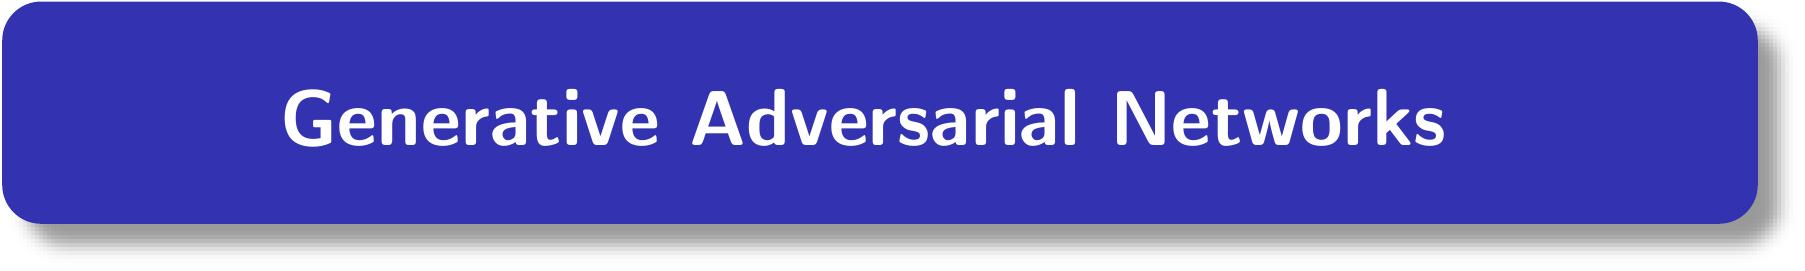

In [8]:
import base64
from IPython.display import Image, display

def display_base64_image(base64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # Display the image
    display(Image(data=image_data))

display_base64_image(images[0])

## Summarize the data

Create a summary of each element extracted from the PDF. This summary will be vectorized and used in the retrieval process.

In [50]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

In [66]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline


model_name = "meta-llama/Llama-3.2-1B"  # Needs authentication from Hugging Face
tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token=True)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", torch_dtype="auto")

# Set up the text generation pipeline
summarizer = pipeline("text-generation", model=model, tokenizer=tokenizer)

def summarize(text):
    prompt = f"""
You are an assistant tasked with summarizing tables and text.
Give a concise summary of the table or text.

Respond only with the summary, no additional comment.
Do not start your message by saying "Here is a summary" or anything like that.
Just give the summary as it is.

Table or text chunk: {text}
"""
    result = summarizer(prompt, max_new_tokens=200, do_sample=False)
    return result[0]['generated_text'].split("Table or text chunk:")[1].strip()


/home/jac/miniconda3/envs/tf/lib/python3.9/site-packages/transformers/models/auto/tokenization_auto.py:786: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/home/jac/miniconda3/envs/tf/lib/python3.9/site-packages/accelerate/utils/modeling.py:1462: UserWarning: Current model requires 1088 bytes of buffer for offloaded layers, which seems does not fit any GPU's remaining memory. If you are experiencing a OOM later, please consider using offload_buffers=True.
  warnings.warn(


In [67]:
# Prompt
prompt_text = """
You are an assistant tasked with summarizing tables and text.
Give a concise summary of the table or text.

Respond only with the summary, no additionnal comment.
Do not start your message by saying "Here is a summary" or anything like that.
Just give the summary as it is.

Table or text chunk: {element}

"""
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
model = ChatGroq(temperature=0.5, model="llama-3.1-8b-instant")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

In [9]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda, RunnableMap
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

# HF model setup
model_name = "meta-llama/Llama-3.2-1B"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token=True)
hf_model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", torch_dtype="auto")
hf_pipe = pipeline("text-generation", model=hf_model, tokenizer=tokenizer)

# LangChain wrapper for HF pipeline
def run_hf_pipeline(input_text):
    result = hf_pipe(input_text, max_new_tokens=200, do_sample=False)
    return result[0]['generated_text']

# Prompt setup (LangChain style)
prompt_text = """
You are an assistant tasked with summarizing tables and text.
Give a concise summary of the table or text.

Respond only with the summary, no additional comment.
Do not start your message by saying "Here is a summary" or anything like that.
Just give the summary as it is.

Table or text chunk: {element}
"""
prompt = PromptTemplate.from_template(prompt_text)

# Chain setup
summarize_chain = (
    {"element": lambda x: x}
    | prompt
    | RunnableLambda(run_hf_pipeline)
    | StrOutputParser()
)


/home/jac/miniconda3/envs/tf/lib/python3.9/site-packages/transformers/models/auto/tokenization_auto.py:786: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
Some parameters are on the meta device because they were offloaded to the cpu.


In [10]:
from langchain_core.runnables import RunnableLambda
from langchain_core.output_parsers import StrOutputParser

def run_hf_pipeline(input_prompt):
    # Convert from LangChain's StringPromptValue to a plain string
    if hasattr(input_prompt, "to_string"):
        input_prompt = input_prompt.to_string()
    result = hf_pipe(input_prompt, max_new_tokens=200, do_sample=False)
    return result[0]['generated_text']


In [ ]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline

# Model: Free & summarization-trained
model_name = "google/flan-t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# HF summarization pipeline
hf_pipe = pipeline("text2text-generation", model=model, tokenizer=tokenizer)

# LangChain-compatible wrapper
def run_hf_pipeline(input_prompt):
    if hasattr(input_prompt, "to_string"):
        input_prompt = input_prompt.to_string()
    result = hf_pipe(input_prompt, max_new_tokens=150, do_sample=False)
    return result[0]['generated_text']

# Prompt (summarization-focused)
prompt_text = """
Summarize the following table or text into a concise statement.

Input: {element}
"""

prompt = PromptTemplate.from_template(prompt_text)

# Summarization Chain
summarize_chain = (
    {"element": lambda x: x}
    | prompt
    | RunnableLambda(run_hf_pipeline)
    | StrOutputParser()
)

# Example: use batch mode
text_summaries = summarize_chain.batch(texts, config={"max_concurrency": 3})
tables_html = [table.metadata.text_as_html for table in tables]
table_summaries = summarize_chain.batch(tables_html, config={"max_concurrency": 3})


In [84]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from transformers import AutoProcessor, BlipForConditionalGeneration
from PIL import Image
import torch

# 1. Load image-to-text model for image captioning
caption_model_id = "Salesforce/blip-image-captioning-base"
processor = AutoProcessor.from_pretrained(caption_model_id)
caption_model = BlipForConditionalGeneration.from_pretrained(caption_model_id).to("cuda" if torch.cuda.is_available() else "cpu")

# 2. Load GPT-2 style model for text summarization
gpt2_model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(gpt2_model_name)
gpt2_model = AutoModelForCausalLM.from_pretrained(gpt2_model_name)
hf_pipe = pipeline("text-generation", model=gpt2_model, tokenizer=tokenizer)

# 3. Step: Caption the image using BLIP
def image_to_caption(img: Image.Image) -> str:
    inputs = processor(images=img, return_tensors="pt").to(caption_model.device)
    output_ids = caption_model.generate(**inputs, max_new_tokens=64, pad_token_id=processor.tokenizer.eos_token_id)
    caption = processor.batch_decode(output_ids, skip_special_tokens=True)[0]
    return caption.strip()

# 4. Step: Feed image caption to GPT-2 with prompt
prompt_template = """
You are an assistant tasked with summarizing a caption generated from a research paper image.
Focus on highlighting meaningful aspects of the image, especially any figures or graphs.

Caption text: {element}
"""

prompt = PromptTemplate.from_template(prompt_template)

def run_gpt2_pipeline(input_prompt):
    if hasattr(input_prompt, "to_string"):
        input_prompt = input_prompt.to_string()
    result = hf_pipe(input_prompt, max_new_tokens=100, do_sample=False)
    return result[0]['generated_text']

# 5. LangChain Chain
summarize_chain = (
    {"element": lambda x: x}
    | prompt
    | RunnableLambda(run_gpt2_pipeline)
    | StrOutputParser()
)

# 6. Final pipeline: image → caption → GPT2 summary
def summarize_image(img: Image.Image) -> str:
    caption = image_to_caption(img)
    return summarize_chain.invoke(caption)

# 7. For multiple images:
def summarize_images(image_list):
    return [summarize_image(img) for img in image_list]

# ✅ Example usage
# from PIL import Image
# img1 = Image.open("transformer_diagram.jpg")
# summaries = summarize_images([img1])
# print(summaries[0])


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [13]:
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
from PIL import Image
import torch
import base64
from io import BytesIO

# Load model, processor, tokenizer
model_name = "nlpconnect/vit-gpt2-image-captioning"
model = VisionEncoderDecoderModel.from_pretrained(model_name)
feature_extractor = ViTImageProcessor.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Helper: Convert base64 image string to PIL Image
def decode_image(base64_image_str):
    image_bytes = base64.b64decode(base64_image_str)
    return Image.open(BytesIO(image_bytes)).convert("RGB")

# Image description function
def describe_image(base64_image_str):
    image = decode_image(base64_image_str)
    pixel_values = feature_extractor(images=image, return_tensors="pt").pixel_values.to(device)

    output_ids = model.generate(
    pixel_values,
    attention_mask=torch.ones(pixel_values.shape[:2], device=device),  # All 1s mask
    max_length=64,
    num_beams=4
)

    caption = tokenizer.decode(output_ids[0], skip_special_tokens=True).strip()
    return caption


/home/jac/miniconda3/envs/tf/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [14]:
# Assume 'images' is a list of base64 strings
image_summaries = [describe_image(img) for img in images]


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


In [15]:
image_summaries

['a blue and white sign on a blue background',
 'a blue and white photo of a blue and white airplane',
 'a series of street signs on a pole',
 'a blue and white sign on a blue background',
 'a sign that is on the side of a building',
 'a blue and white sign on a blue background',
 'a street sign with a clock on top of it',
 'a blue and white sign on a blue background',
 'a collage of a street sign and a clock',
 'a blue and white sign on a blue background',
 'a collage of a number of signs on a computer screen',
 'a blue and white sign on a blue background',
 'a collage of photos of a person wearing a hat',
 'a blue and white sign on a blue background',
 'a drawing of a person wearing a hat and tie',
 'a blue and white sign on a blue background',
 'a collage of photos of a person wearing a hat',
 'a blue and white photo of a blue and white clock',
 'a collage of a number of signs on a computer screen',
 'a blue and white photo of a blue and white clock',
 'a sign that is on top of a pi

In [16]:
print(image_summaries[1])

a blue and white photo of a blue and white airplane


In [17]:
image_summaries

['a blue and white sign on a blue background',
 'a blue and white photo of a blue and white airplane',
 'a series of street signs on a pole',
 'a blue and white sign on a blue background',
 'a sign that is on the side of a building',
 'a blue and white sign on a blue background',
 'a street sign with a clock on top of it',
 'a blue and white sign on a blue background',
 'a collage of a street sign and a clock',
 'a blue and white sign on a blue background',
 'a collage of a number of signs on a computer screen',
 'a blue and white sign on a blue background',
 'a collage of photos of a person wearing a hat',
 'a blue and white sign on a blue background',
 'a drawing of a person wearing a hat and tie',
 'a blue and white sign on a blue background',
 'a collage of photos of a person wearing a hat',
 'a blue and white photo of a blue and white clock',
 'a collage of a number of signs on a computer screen',
 'a blue and white photo of a blue and white clock',
 'a sign that is on top of a pi

In [26]:
import torch
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration
import base64
from io import BytesIO

# Load model and processor
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to("cuda" if torch.cuda.is_available() else "cpu")

# Decode image from base64
def decode_image(b64_string):
    return Image.open(BytesIO(base64.b64decode(b64_string))).convert("RGB")

# Generate caption
def describe_image(base64_image_str):
    image = decode_image(base64_image_str)
    inputs = processor(images=image, return_tensors="pt").to(model.device)

    output = model.generate(**inputs, max_new_tokens=64)
    caption = processor.batch_decode(output, skip_special_tokens=True)[0]
    return caption


preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/527 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

/home/jac/miniconda3/envs/tf/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [27]:
# Assume 'images' is a list of base64 strings
image_summaries = [describe_image(img) for img in images]


In [28]:
image_summaries

['general general services',
 'the logo for the company',
 'a diagram of the different types of the algorithm',
 'the logo for the global medical group',
 'a simple example of a simple example of a simple example of a simple example of a simple example of a',
 'the logo for the global medical group',
 'a diagram of a generator generator',
 'the logo for the global medical group',
 'a diagram of a generator generator',
 'the logo for the global medical group',
 'a diagram of a neural neural',
 'the logo for the global medical group',
 'a police officer and a police officer',
 'the logo for the global medical group',
 'a cartoon of two police officers with a speech bubble',
 'the logo for the global medical group',
 'a picture of a man in a police uniform and a man in a police uniform',
 'the logo for the new website',
 'a diagram of a neural neural',
 'the logo for the new website',
 'the fourier equation is a simple representation',
 'a diagram of a neural neural',
 'the logo for the o